In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Baca dataset asli
df = pd.read_csv('dataset_dummy.csv')

# Encode genre_seni dan user_id
genre_encoder = LabelEncoder()
user_encoder = LabelEncoder()

df['genre_encoded'] = genre_encoder.fit_transform(df['genre_seni'])
df['user_encoded'] = user_encoder.fit_transform(df['user_id'])

# Jumlah unik genre dan user
n_genres = df['genre_encoded'].nunique()
n_users = df['user_encoded'].nunique()

In [ ]:
# Embedding size
embedding_size = 64

In [ ]:
# Input layer
user_input = Input(shape=(1,), name='user_input')
genre_input = Input(shape=(1,), name='genre_input')

# Embedding layer
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size, input_length=1, name='user_embedding')(user_input)
genre_embedding = Embedding(input_dim=n_genres, output_dim=embedding_size, input_length=1, name='genre_embedding')(genre_input)

# Flatten embedding
user_vector = Flatten(name='user_vector')(user_embedding)
genre_vector = Flatten(name='genre_vector')(genre_embedding)

# Dot product of user and genre vectors
dot_product = Dot(axes=1, name='dot_product')([user_vector, genre_vector])

In [ ]:
# Model
model = Model(inputs=[user_input, genre_input], outputs=dot_product)
# model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

# Latih model
history = model.fit([df['user_encoded'], df['genre_encoded']], df['rating'], epochs=500, verbose=1)

# Mendapatkan embedding dari model yang sudah dilatih
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
genre_embeddings = model.get_layer('genre_embedding').get_weights()[0]

Epoch 1/500
18/18 [==============================] - 1s 2ms/step - loss: 39.2296 - mean_squared_error: 39.2296
Epoch 2/500
18/18 [==============================] - 0s 2ms/step - loss: 39.1668 - mean_squared_error: 39.1668
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 39.0852 - mean_squared_error: 39.0852
Epoch 4/500
18/18 [==============================] - 0s 2ms/step - loss: 38.9364 - mean_squared_error: 38.9364
Epoch 5/500
18/18 [==============================] - 0s 2ms/step - loss: 38.6718 - mean_squared_error: 38.6718
Epoch 6/500
18/18 [==============================] - 0s 2ms/step - loss: 38.2142 - mean_squared_error: 38.2142
Epoch 7/500
18/18 [==============================] - 0s 2ms/step - loss: 37.4812 - mean_squared_error: 37.4812
Epoch 8/500
18/18 [==============================] - 0s 2ms/step - loss: 36.4076 - mean_squared_error: 36.4076
Epoch 9/500
18/18 [==============================] - 0s 2ms/step - loss: 34.9413 - mean_squared_error: 34.9413
E

In [ ]:
# # Plot training loss and RMSE
# plt.figure(figsize=(12, 5))

# # Plot loss
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()

# # Plot RMSE
# plt.subplot(1, 2, 2)
# plt.plot(history.history['root_mean_squared_error'], label='RMSE')
# plt.xlabel('Epochs')
# plt.ylabel('RMSE')
# plt.title('Training RMSE')
# plt.legend()

# plt.tight_layout()
# plt.show()

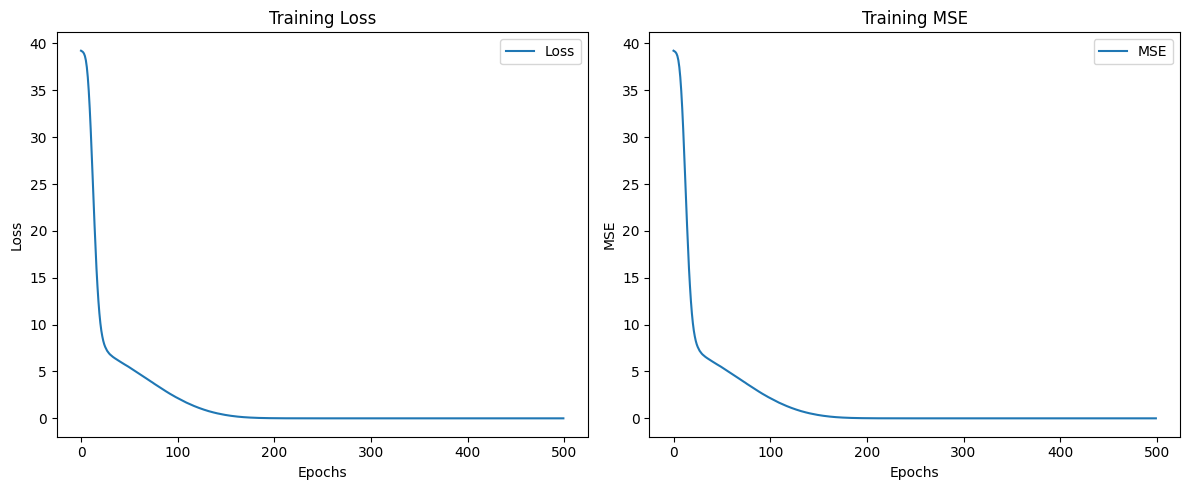

In [ ]:
# Plot training loss and RMSE
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training MSE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Fungsi rekomendasi berdasarkan embedding
def recommend_art_based_on_genre_deep(user_id):
    # Mendapatkan embedding pengguna yang diberikan
    user_index = user_encoder.transform([user_id])[0]
    user_embedding = user_embeddings[user_index]

    # Menghitung skor untuk setiap genre
    scores = np.dot(genre_embeddings, user_embedding)

    # Mengurutkan genre berdasarkan skor tertinggi
    recommended_genre_indices = np.argsort(scores)[::-1]
    recommended_genres = genre_encoder.inverse_transform(recommended_genre_indices)

    return recommended_genres

In [ ]:
# Fungsi untuk memberikan rekomendasi berdasarkan input pengguna baru tanpa menambah ke CSV
def recommend_art_for_new_user(new_user_ratings, num_recommendations=5):
    # Hitung embedding untuk user baru sebagai rata-rata embedding dari genre yang sudah dirating
    rated_genres = [rating[0] for rating in new_user_ratings]
    rated_ratings = [rating[1] for rating in new_user_ratings]

    rated_genre_indices = genre_encoder.transform(rated_genres)
    new_user_embedding = np.average(genre_embeddings[rated_genre_indices], axis=0, weights=rated_ratings)

    # Hitung kesamaan (similarity) antara embedding user baru dan semua embedding genre
    similarities = np.dot(genre_embeddings, new_user_embedding)

    # Mendapatkan genre seni dengan skor tertinggi
    recommended_indices = np.argsort(similarities)[-num_recommendations:][::-1]
    recommended_genres = genre_encoder.inverse_transform(recommended_indices)

    return recommended_genres

In [ ]:
# Contoh penggunaan untuk user baru dengan id 102
new_user_ratings = [
    ('Impressionism', 10),
    ('Fauvism', 5),
    ('Pop', 8),
    ('Nouveau', 3)
]

recommended_genres = recommend_art_for_new_user(new_user_ratings, num_recommendations=5)
print(f"Rekomendasi genre seni untuk User 102: {recommended_genres}")

Rekomendasi genre seni untuk User 102: ['Impressionism' 'Pop' 'Nouveau' 'Fauvism' 'Surrealism']
